**Análise Exploratória**

**Parte 1: Parsing da Base de Dados**

In [13]:
sc = SparkContext.getOrCreate()

In [34]:
import os
import numpy as np

filename = os.path.join("Data","Aula03","Crime.csv")
CrimeRDD = sc.textFile(filename,8)
header = CrimeRDD.take(1)[0] # o cabeçalho é a primeira linha do arquivo

print "Campos disponíveis: {}".format(header)

Campos disponíveis: Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y


In [37]:
# EXERCICIO
CrimeHeadlessRDD = CrimeRDD.filter(lambda x: x!=header)

firstObject = CrimeHeadlessRDD.take(1)[0]
print firstObject

2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747


In [38]:
assert firstObject==u'2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747', 'valor incorreto'
print "OK"

OK


In [41]:
# EXERCICIO
CrimeHeadlessRDD = (CrimeRDD
                    .filter(lambda x: x!=header)
                    .map(lambda x: x.split(','))
                    )
                   

firstObjectList = CrimeHeadlessRDD.take(1)[0]
print firstObjectList

[u'2015-05-13 23:53:00', u'WARRANTS', u'WARRANT ARREST', u'Wednesday', u'NORTHERN', u'"ARREST', u' BOOKED"', u'OAK ST / LAGUNA ST', u'-122.425891675136', u'37.7745985956747']


In [42]:
assert firstObjectList[0]==u'2015-05-13 23:53:00', 'valores incorretos'
print "OK"

OK


In [56]:
# EXERCICIO

import re
import datetime
from collections import namedtuple

headeritems = header.split(',') # transformar o cabeçalho em lista
del headeritems[-1] # apagar o último item e...
headeritems[-1] = 'COORD' # transformar em COORD

# Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,COORD
Crime = namedtuple('Crime',headeritems) # gera a namedtuple Crime com os campos de header

REGEX = r',(?=(?:[^"]*"[^"]*")*(?![^"]*"))'
# buscar por "," tal que após essa vírgula (?=) ou exista um par de "" ou não tenha " sozinha
# ?= indica para procurarmos pelo padrão após a vírgula
# ?: significa para não interpretar os parênteses como captura de valores
# [^"]* 0 ou sequências de caracteres que não sejam aspas
# [^"]*"[^"]*"  <qualquer caracter exceto aspas> " <qualquer caracter exceto aspas> "
# ?! indica para verificar se não existe tal padrão a frente da vírgula


def ParseCrime(rec):
    # utilizando re.split() vamos capturar nossos valores
    Date, Category, Descript, DayOfWeek, PdDistrict, Resolution, Address, X, Y = tuple(re.split(REGEX,rec))
    
    # Converta a data para o formato datetime
    Date = datetime.datetime.strptime(Date, "%Y-%m-%d %H:%M:%S")
    
    # COORD é uma tupla com floats representando X e Y
    COORD =(X,Y)
    
    # O campo 'Resolution' será uma lista dos valores separados por vírgula, sem as aspas
    Resolution = map(lambda x: x.strip(), Resolution.split(','))
    return Crime(Date, Category, Descript, DayOfWeek, PdDistrict, Resolution, Address, COORD)

# Aplique a função ParseCrime para cada objeto da base
CrimeHeadlessRDD = (CrimeRDD
                    .filter(lambda x: x!=header)
                    .map(ParseCrime)
                    )

firstClean = CrimeHeadlessRDD.take(1)[0]
totalRecs = CrimeHeadlessRDD.count()
print firstClean

Crime(Dates=datetime.datetime(2015, 5, 13, 23, 53), Category=u'WARRANTS', Descript=u'WARRANT ARREST', DayOfWeek=u'Wednesday', PdDistrict=u'NORTHERN', Resolution=[u'"ARREST', u'BOOKED"'], Address=u'OAK ST / LAGUNA ST', COORD=(u'-122.425891675136', u'37.7745985956747'))


In [57]:

assert type(firstClean.Dates) is datetime.datetime and type(firstClean.Resolution) is list and type(firstClean.COORD) is tuple,'tipos incorretos'
print "OK"

assert CrimeHeadlessRDD.filter(lambda x: len(x)!=8).count()==0, 'algo deu errado!'
print "OK"

assert totalRecs==878049, 'total de registros incorreto'
print "OK"

OK
OK
OK


**Parte 2: Estatísticas Básicas das Variáveis**

**
(2a) Contagem de frequência**

In [62]:
# EXERCICIO

CatCountRDD = (CrimeHeadlessRDD
               .map(lambda x: (x.Category,1)) # mapear a variável de interesse, no caso (Category)
               .reduceByKey(lambda x,y: x+y) #soma a quantidade total de cada tipo de crime 
               )
              
catCount = sorted(CatCountRDD.collect(), key=lambda x: -x[1])
print catCount

[(u'LARCENY/THEFT', 174900), (u'OTHER OFFENSES', 126182), (u'NON-CRIMINAL', 92304), (u'ASSAULT', 76876), (u'DRUG/NARCOTIC', 53971), (u'VEHICLE THEFT', 53781), (u'VANDALISM', 44725), (u'WARRANTS', 42214), (u'BURGLARY', 36755), (u'SUSPICIOUS OCC', 31414), (u'MISSING PERSON', 25989), (u'ROBBERY', 23000), (u'FRAUD', 16679), (u'FORGERY/COUNTERFEITING', 10609), (u'SECONDARY CODES', 9985), (u'WEAPON LAWS', 8555), (u'PROSTITUTION', 7484), (u'TRESPASS', 7326), (u'STOLEN PROPERTY', 4540), (u'SEX OFFENSES FORCIBLE', 4388), (u'DISORDERLY CONDUCT', 4320), (u'DRUNKENNESS', 4280), (u'RECOVERED VEHICLE', 3138), (u'KIDNAPPING', 2341), (u'DRIVING UNDER THE INFLUENCE', 2268), (u'RUNAWAY', 1946), (u'LIQUOR LAWS', 1903), (u'ARSON', 1513), (u'LOITERING', 1225), (u'EMBEZZLEMENT', 1166), (u'SUICIDE', 508), (u'FAMILY OFFENSES', 491), (u'BAD CHECKS', 406), (u'BRIBERY', 289), (u'EXTORTION', 256), (u'SEX OFFENSES NON FORCIBLE', 148), (u'GAMBLING', 146), (u'PORNOGRAPHY/OBSCENE MAT', 22), (u'TREA', 6)]


In [63]:
assert catCount[0][1]==174900, 'valores incorretos'
print "OK"

OK


In [70]:
# EXERCICIO

RegionCountRDD = (CrimeHeadlessRDD
                  .map(lambda x: (x.PdDistrict,1)) # mapear a variável de interesse, no caso (PdDistrict)
                  .reduceByKey(lambda x,y: x+y) # #soma a quantidade total de cada região 
                 )
regCount = sorted(RegionCountRDD.collect(), key=lambda x: -x[1])
print regCount

[(u'SOUTHERN', 157182), (u'MISSION', 119908), (u'NORTHERN', 105296), (u'BAYVIEW', 89431), (u'CENTRAL', 85460), (u'TENDERLOIN', 81809), (u'INGLESIDE', 78845), (u'TARAVAL', 65596), (u'PARK', 49313), (u'RICHMOND', 45209)]


In [71]:
assert regCount[0][1]==157182, 'valores incorretos'
print "OK"

OK


**(2b) Cálculo da Média**

In [111]:
# EXERCICIO

from operator import add

# Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,COORD

# Lambda para converter um datetime em `Dia-Mes-Ano`
day2str = lambda x: '{}-{}-{}'.format(x.day,x.month,x.year)

totalDatesRDD = (CrimeHeadlessRDD
                 .map(lambda x: ((day2str(x.Dates),x.DayOfWeek),1)) #criar uma RDD de tuplas em que o primeiro campo é a tupla da data no formato 'dia-mes-ano' e do dia da semana e o segundo campo o valor 1.
                 .reduceByKey(lambda x,y: x) #reduzir a RDD sem efetuar a soma, mantendo o valor 1.
                 .map(lambda x: (x[0][1], x[1])) # efetuar o mapeamento de (DayOfWeek,1) 
                 .reduceByKey(x,y: x+y) #redução com soma para contabilizar quantas vezes cada dia da semana aparece na base de dados.                 )
                )
crimesWeekDayRegionRDD = (CrimeHeadlessRDD
                 .map(lambda x: ((x.DayOfWeek, x.PdDistrict),1)) #RDD terá como chave uma tupla ( (DayOfWeek, PdDistrict), 1)
                 .reduceByKey(x,y: x+y) #contabilizar quantos crimes ocorreram em determinada região e naquele dia da semana
                 .map(lambda x: (x[0][0],(x[0][1],x[1]))) # Após a redução, devemos mapear esse RDD para (DayOfWeek, (PdDistrict, contagem))
                  )
                

RegionAvgPerDayRDD = (crimesWeekDayRegionRDD
                 .join(totalDatesRDD)#juntar as duas RDDs uma vez que elas possuem a mesma chave (DayOfWeek)
                 .map(lambda x: (x[0],(x[1][0][0],x[1][0][1]/float(x[1][1])))) #mapeamento para:(DayOfWeek,(PdDistrict,contagem/contagemDiaDaSemana))
                 .groupByKey() #o resultado é agrupado pela chave, gerando uma tupla ( DayOfWeek, [ (Pd1, media1), (Pd2, media2), ... ] )
                 .map(lambda x: (x[0],dict(x[1])))#essa lista é mapeada para um dicionário com o comando dict.
                 )

RegionAvg = RegionAvgPerDayRDD.collectAsMap()
print RegionAvg['Sunday']

{u'CENTRAL': 37.99688473520249, u'NORTHERN': 44.45794392523364, u'SOUTHERN': 64.82866043613707, u'PARK': 20.70404984423676, u'MISSION': 49.45171339563863, u'TENDERLOIN': 31.707165109034268, u'RICHMOND': 18.968847352024923, u'TARAVAL': 25.953271028037385, u'INGLESIDE': 32.230529595015575, u'BAYVIEW': 37.27414330218068}


In [112]:
assert np.round(RegionAvg['Sunday']['BAYVIEW'],2)==37.27, 'valores incorretos {}'.format(np.round(RegionAvg[0][2],2))
print "OK"

OK


**(2c) Média e Desvio-Padrão pelo PySpark **

In [137]:
# EXERCICIO

countWeekDayDistRDD = (CrimeHeadlessRDD
                       .map(lambda x: ((day2str(x.Dates),x.DayOfWeek,x.PdDistrict),1)) #Gere uma RDD contendo a tupla ( (Dates,DayOfWeek, PdDistrict), contagem)
                       .reduceByKey(x,y: x+y)
                       .map(lambda x: ((x[0][1],x[0][2]),x[1])) #mapeie para ( (DayOfWeek,PdDistrict), Contagem) 
                       .groupByKey() #agrupamento pela chave
                       )
# Esse procedimento só é viável se existirem poucas chaves
RegionAvgSpark = {}
Keys = countWeekDayDistRDD.map(lambda rec: rec[0]).collect()
for key in Keys:
    listRDD = (countWeekDayDistRDD
               .filter(lambda rec: rec[0]==key)
               .flatMap(lambda rec: rec[1])
               )
    if key[0] not in RegionAvgSpark:
        RegionAvgSpark[key[0]] = {}    
    RegionAvgSpark[key[0]][key[1]] = (listRDD.mean(), listRDD.stdev())
    
print RegionAvgSpark['Sunday']


**Parte 3: Plotagem de Gráficos**


**(3a) Gráfico de Barras**

In [140]:
import matplotlib.pyplot as plt

# Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,COORD

# Lambda para converter um datetime em `Dia-Mes-Ano`
day2str = lambda x: '{}-{}-{}'.format(x.day,x.month,x.year)

totalDatesRDD = (CrimeHeadlessRDD
                 .map(lambda rec: (day2str(rec.Dates),1))
                 .reduceByKey(lambda x,y: x)
                 )

totalDays = float(totalDatesRDD.count())

avgCrimesRegionRDD = (RegionCountRDD
                      .map(lambda rec: (rec[0],rec[1]/totalDays))
                     )

Xticks,Y = zip(*avgCrimesRegionRDD.collectAsMap().items())
indices = np.arange(len(Xticks))
width = 0.35

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.bar(indices,Y, width)
plt.grid(b=True, which='major', axis='y')
plt.xticks(indices+width/2., Xticks, rotation=17 )
plt.ylabel('Number of crimes')
plt.xlabel('Region')
pass

In [141]:
# Dias da semana como referência
Day = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

# Uma cor para cada dia
Color = ['r','b','g','y','c','k','purple']

# Dicionário (dia, array de médias)
Y = {}
for day in Day:
    Y[day] = np.array([RegionAvg[day][x] for x in Xticks])

# Matriz dias x regiões    
Bottom = np.zeros( (len(Day),len(Xticks)) )
for i in range(1,len(Day)):
    Bottom[i,:] = Bottom[i-1,:]+Y[Day[i-1]]
    
indices = np.arange(len(Xticks))
width = 0.35

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')

# Gera uma lista de plots, um para cada dia
plots = [plt.bar(indices,Y[Day[i]], width, color=Color[i], bottom=Bottom[i]) for i in range(len(Day))]

plt.legend( [p[0] for p in plots], Day,loc='center left', bbox_to_anchor=(1, 0.5) ) 
    
plt.grid(b=True, which='major', axis='y')
plt.xticks(indices+width/2., Xticks, rotation=17 )
plt.ylabel('Number of crimes')
plt.xlabel('Region')
pass

In [142]:
assert regCount[0][1]==157182, 'valores incorretos'
print "OK"

OK


**(3b) Gráfico de Linha **

In [192]:
# EXERCICIO

parseWeekday = lambda x: '{}-{}-{}'.format(x.day, x.month, x.year)

 #Gera um RDD contendo um único registro de cada hora para cada dia
hoursRDD = (CrimeHeadlessRDD
            .map(lambda x: ((parseWeekday(x.Dates),x.Dates.hour),1))
            .reduceByKey(x,y: x+y)
            )
 

#Em seguida, contabilizamos a soma da quantidade de crime em cada hora. 
         
crimePerHourRDD = (CrimeHeadlessRDD
                    .map(lambda x: (x.Dates.hour,1))
                    .reduceByKey(x,y: x+y)  #redução com soma para contabilizar a quantidade de crime em cada hora
                  )
#Finalmente, juntamos as duas RDDs 
avgCrimeHourRDD = (crimePerHourRDD
                   .join(hoursRDD)
                   )

crimePerHour = avgCrimeHourRDD.collect()
print crimePerHour[0:5]

In [194]:
crimePerHourSort = sorted(crimePerHour,key=lambda x: x[0])

X,Y = zip(*crimePerHourSort)

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.plot(X,Y)
plt.grid(b=True, which='major', axis='y')
plt.ylabel('Avg. Number of crimes')
plt.xlabel('Hour')
pass

ValueError: need more than 0 values to unpack

**(3c) Gráfico de Dispersão**

In [217]:
# EXERCICIO
parseMonthYear = lambda x: '{}-{}'.format(x.month, x.year)

crimes = map(lambda x: x[0], catCount)

datesCrimesRDD = (CrimeHeadlessRDD
#construir uma RDD em que cada registro corresponde a uma data o valor contido nele é a quantidade de crimes de cada tipo.
#O primeiro passo é criar uma RDD com a tupla ( (Mes-Ano, Crime), 1 )
                  .map(lambda x:((parseMonthYear(x.Dates),x.Category),1))
#utilizá-la para gerar a tupla ( (Mes-Ano,Crime) Quantidade ).
                  .reduceByKey(x,y: x+y)
#Mapeamos essa RDD para definir Mes-Ano como chave 
                  .map(lambda x: (x[0][0],(x[0][1],x[1])))
#agrupamos em torno dessa chave, gerando uma lista de quantidade de crimes em cada data.
                  .groupByKey()
# Aplicamos a função dict() nessa lista para obtermos uma RDD no seguinte formato: (Mes-Ano, {CRIME: quantidade}).
                  .map(lambda x: (x[0],dict(x[1])))
                  .cache()
                 )
print datesCrimesRDD.take(1)   


[('2-2007', {u'KIDNAPPING': 12, u'WEAPON LAWS': 49, u'SECONDARY CODES': 61, u'WARRANTS': 296, u'LOITERING': 4, u'EMBEZZLEMENT': 13, u'FRAUD': 87, u'DRIVING UNDER THE INFLUENCE': 13, u'VEHICLE THEFT': 212, u'ROBBERY': 135, u'BURGLARY': 192, u'SUSPICIOUS OCC': 207, u'RECOVERED VEHICLE': 30, u'ASSAULT': 456, u'FORGERY/COUNTERFEITING': 81, u'BAD CHECKS': 3, u'DRUNKENNESS': 24, u'GAMBLING': 2, u'OTHER OFFENSES': 757, u'SUICIDE': 3, u'ARSON': 5, u'DRUG/NARCOTIC': 504, u'SEX OFFENSES NON FORCIBLE': 2, u'PROSTITUTION': 76, u'VANDALISM': 237, u'NON-CRIMINAL': 490, u'LIQUOR LAWS': 17, u'TRESPASS': 50, u'SEX OFFENSES FORCIBLE': 23, u'STOLEN PROPERTY': 19, u'BRIBERY': 3, u'FAMILY OFFENSES': 4, u'MISSING PERSON': 154, u'DISORDERLY CONDUCT': 24, u'RUNAWAY': 13, u'LARCENY/THEFT': 835})]


In [218]:
assert datesCrimesRDD.take(1)[0][1][u'KIDNAPPING']==12,'valores incorretos'
print 'ok' 

ok


In [230]:
# EXERCICIO

totalPerDateRDD = (CrimeHeadlessRDD
#O próximo passo consiste em calcular o total de pares Mes-Ano para ser possível o cálculo da média.
                   .map(lambda x:((x.Dates),1))
                   .reduceByKey(lambda x,y: x+y)
                  )
fractionCrimesDateRDD = (datesCrimesRDD
                         .<COMPLETAR>
                         .<COMPLETAR>
                         .cache()
                        )

print fractionCrimesDateRDD.take(1)


In [ ]:
from pyspark.mllib.stat import Statistics
corr = Statistics.corr(fractionCrimesDateRDD.map(lambda rec: map(lambda x: x[1],rec[1])))
print corr

In [ ]:
npCorr = np.array(corr)
rowMin = npCorr.min(axis=1).argmin()
colMin = npCorr[rowMin,:].argmin()
print crimes[rowMin], crimes[colMin], npCorr[rowMin,colMin]

npCorr[npCorr==1.] = 0.
rowMax = npCorr.max(axis=1).argmax()
colMax = npCorr[rowMax,:].argmax()
print crimes[rowMax], crimes[colMax], npCorr[rowMax,colMax]

**(3d) Histograma**

In [241]:

bookedRDD = (CrimeHeadlessRDD
# RDD chamada bookedRDD que contém apenas os registros contendo ARREST no campo Resolution (lembre-se que esse campo é uma lista)
             .filter(lambda x: 'ARREST' == x.Resolution)
             .map(lambda x: ((x.Dates),1))
#contabilizar a quantidade de registros em cada 'Mes-Ano'
             .reduceByKey(lambda x,y: x+y)
            )

Data = bookedRDD.collect()
print Data[:5]




[]


In [ ]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.hist(Data)
plt.grid(b=True, which='major', axis='y')
plt.xlabel('ARRESTED')
pass

**(3e) Box-plot**

In [244]:
parseDayMonth = lambda x: '{}-{}'.format(x.month,x.year)

#Para esse exercício vamos plotar duas box-plot sobre a média do número de prisões durante os meses analisados para os crimes 
#do tipo ROBBERY e ASSAULT.
#O mapeamento é exatamente o mesmo do exercício anterior, porém filtrando para o tipo de roubo analisado.

robberyBookedRDD = (CrimeHeadlessRDD
                    .filter(lambda x: 'ROBBERY' == x.Category)
                    .map(lambda x: (parseDayMonth(x.Dates),1))
#contabilizar a quantidade de registros em cada 'Mes-Ano'
                   .reduceByKey(lambda x,y: x+y)
                   )

assaultBookedRDD = (CrimeHeadlessRDD
                     .filter(lambda x: 'ASSAULT' == x.Category)
                     .map(lambda x: (parseDayMonth(x.Dates),1))
#contabilizar a quantidade de registros em cada 'Mes-Ano'
                     .reduceByKey(lambda x,y: x+y)
                    )

robData = robberyBookedRDD.collect()
assData = assaultBookedRDD.collect()

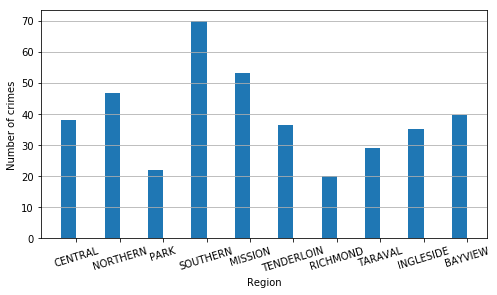

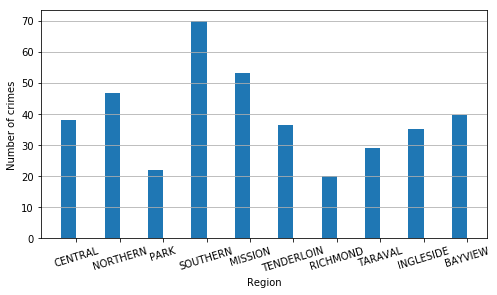

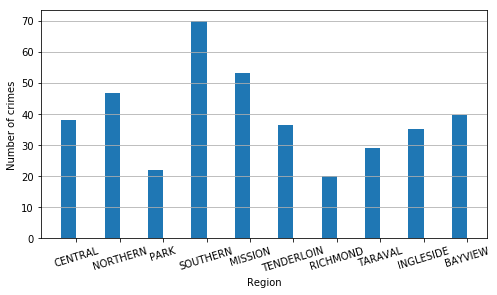

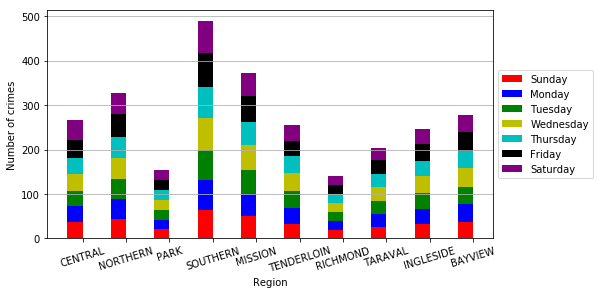

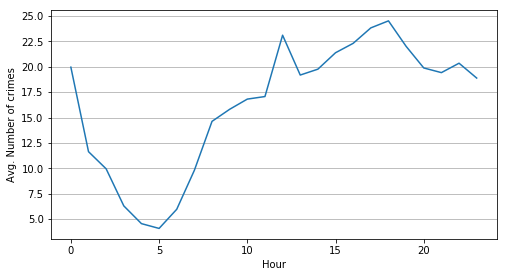

In [246]:
plt.show()